# RealNVP

Real-Valued Non-Volume Preserving Transformation- is the flow-based class of Neural models, which is a tytpe of a probabilistic generative models that uses a sequence of invertible transformations to model complex data distributions

Some key characteristics are:
- Use bijective(invertible) functions, allowing efficien computation of forward of data to latent space and reverse transformation to data space. This means no information will be lost during the recovering from the latent space
- Use of Jacobian Determinant which is essential for handle dimensionality changes without losing data.

Applied areas:
- Density Estimation and Anomaly Detection. The exact likelihood computation makes it easier to identify anomalies
- Image and Vide generation
- Reversible data compression
- Data augmentation for cases when there are lack of original data
- Bayesian Inference and Probabillists modeling when uncertanty needs to be incorporated  
etc.

## INITIALIZATION

### Imports

In [1]:
from sklearn import datasets
from tensorflow.keras import (
    layers,
    regularizers,
    models,
    metrics,
    optimizers,
    callbacks
)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow_probability as tfp
import numpy as np
import tensorflow as tf
import datetime

2024-11-08 00:20:31.636767: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-08 00:20:31.665815: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 00:20:31.665839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 00:20:31.667332: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 00:20:31.672807: I tensorflow/core/platform/cpu_feature_gua

### Functions

In [2]:
def display_img(images, n=10, fig_size=(20, 3), c_map='gray_r', as_type='float32', save_to=None):
    if save_to is not None:
        oFull_path = Path(save_to)
        
        oFull_path.parent.mkdir(parents=True, exist_ok=True)

    
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=fig_size)

    for i in range(n):
        plt.imshow(images[i].astype(as_type), cmap=c_map)
        plt.axis('off')

    # Сохранение изображения
    if save_to:
        plt.savefig(save_to)

    plt.show()

### Dataset generation

By using a scikit library generate a toy dataset with datapoints that forms two interleaving half circles

In [3]:
x, y = datasets.make_moons(30000, noise=5e-2)
x = x.astype('float32')
df = pd.DataFrame(x, columns=['x1', 'x2'])
df['label'] = y

## EDA

### Original

In [4]:
df.shape

(30000, 3)

In [5]:
df.head()

,x1,x2,label
0,0.186446,1.080480,0
1,-0.255368,0.955503,0
2,1.879668,-0.033180,1
3,1.952681,0.170582,1
4,1.881767,0.120212,1


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
x1,30000.0,0.499588,0.867134,-1.190015,-0.041579,0.500812,1.039145,2.184160
x2,30000.0,0.249763,0.496524,-0.652406,-0.204298,0.248295,0.706432,1.161928
label,30000.0,0.500000,0.500008,0.000000,0.000000,0.500000,1.000000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      30000 non-null  float32
 1   x2      30000 non-null  float32
 2   label   30000 non-null  int64  
dtypes: float32(2), int64(1)
memory usage: 468.9 KB


In [8]:
df['label'].value_counts(normalize=True)

label
0    0.5
1    0.5
Name: proportion, dtype: float64

**INTERIM CONCLUSION**

We observe our dataset has been generated without missing data and in accordance with given parametrs. We see that our data is equally balanced and symetricly distributed.  

In a reson of that we see uneven distribution and scale factor between x1 and x2, as well as different centers it is recomended to normalize data

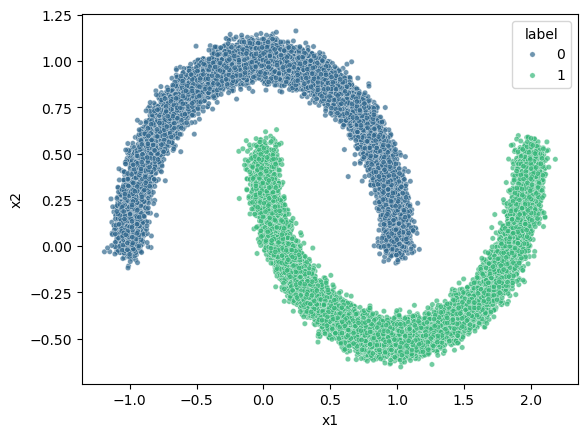

In [9]:
sns.scatterplot(
    data=df, 
    x='x1',
    y='x2',
    hue='label',
    palette='viridis',
    s=15,
    alpha=.7
);

**INTERIM CONCLUSION**

Visualization demonstrates how exactly generated data forms two half circles in the form of moons. Besides we alos see strong non-linear distribution

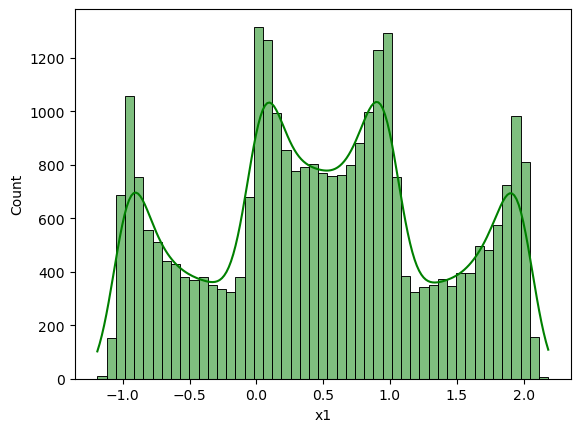

In [10]:
sns.histplot(
    df['x1'],
    kde=True,
    color='green'
);

**INTERIM CONCLUSION**

Here we observe multynidality, formed with four major peaks. 

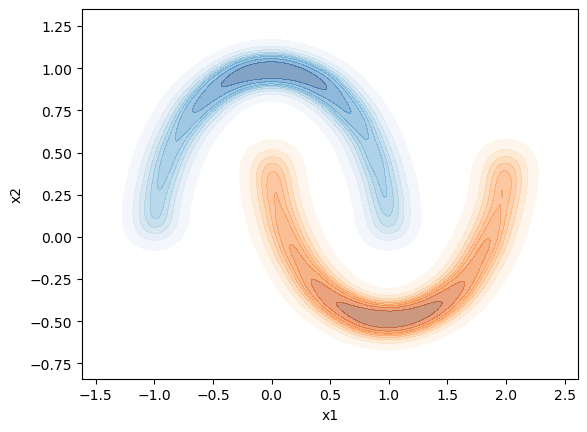

In [11]:
sns.kdeplot(
    data=df[df['label']==0],
    x='x1',
    y='x2',
    cmap='Blues',
    fill=True,
    alpha=.5,
    label='Class 0'
)
sns.kdeplot(
    data=df[df['label']==1],
    x='x1',
    y='x2',
    cmap='Oranges',
    fill=True,
    alpha=.5,
    label='Class 1'
);

**INTERIM CONCLUSION**

This viz demonstrates us a density distributions among 2 groups of data 0 and 1. We see that density distribution is even and symetrical

### Normalization

In [12]:
norm = layers.Normalization()
norm.adapt(x)
x_norm = norm(x)


2024-11-08 00:20:42.697302: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-08 00:20:42.726057: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-08 00:20:42.726110: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-08 00:20:42.729437: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-08 00:20:42.729499: I external/local_xla/xla/stream_executor

In [13]:
norm_df = pd.DataFrame(x_norm, columns=['x1','x2'])
norm_df['label']=y

In [14]:
print('NORMALIZED DATA')
norm_df.describe().T

NORMALIZED DATA


,count,mean,std,min,25%,50%,75%,max
x1,30000.0,4.628499e-07,1.000019,-1.948529,-0.624098,0.001413,0.622243,1.942729
x2,30000.0,-1.013438e-06,1.000017,-1.817001,-0.914497,-0.002958,0.919746,1.837130
label,30000.0,5.000000e-01,0.500008,0.000000,0.000000,0.500000,1.000000,1.000000


In [15]:
print('RAW-GENERATED DATA')
df.describe().T

RAW-GENERATED DATA


,count,mean,std,min,25%,50%,75%,max
x1,30000.0,0.499588,0.867134,-1.190015,-0.041579,0.500812,1.039145,2.184160
x2,30000.0,0.249763,0.496524,-0.652406,-0.204298,0.248295,0.706432,1.161928
label,30000.0,0.500000,0.500008,0.000000,0.000000,0.500000,1.000000,1.000000


**INTERIM CONCLUSION**

We see that after normalization being done our data distribution now more densed around 1, standard deviation is tend to 1 and  mean for both groups are now tends to zero which is desired shape, besides that we now see our data are now evenly scaled.  
Now our data is well fit for machine learning algortyrhms

## BUILD RealNVP

### Coupling Layer

Coupling layer is the key mechanism that allows to build a reversable data transformations

In [16]:
def Coupling(input_dim, coupling_dim, reg):
    '''
    The s-t archtecture is needed in order to maintain reversable data flow transformations by calculating a Jacobian determinant.
    This is become achivable by transforming only half of variables leave the rest untouched
    Args
        input_dim (int): Input layer Dimensionality. Main purpose is identify input vector shape
        coupling_dim (int): Latent layers dimensionality.
        reg (float32): Regularization coefficient
    '''
    input_layer = layers.Input(shape=(input_dim,))

    # Skale component architecture
    # firtst 4 layers have relu activation which helps to learn non-linearity, as well as squize and scale data flow
    # tanh activation on last layer for stability purposes
    s_layer_1 = layers.Dense(
        units=coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(input_layer)

    s_layer_2 = layers.Dense(
        units=coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)

    s_layer_3 = layers.Dense(
        units=coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)

    s_layer_4 = layers.Dense(
        units=coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)

    s_layer_5 = layers.Dense(
        units=coupling_dim,
        activation='tanh',
        kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    # Shift component architecture
    # relu activation uses for to learn non-linearity purposes
    # last layer uses linear activation as we need to shift our data flow with no restrictions
    t_layer_1 = layers.Dense(
        units=coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(input_layer)

    t_layer_2 = layers.Dense(
        units=coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)

    t_layer_3 = layers.Dense(
        units=coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)

    t_layer_4 = layers.Dense(
        units=coupling_dim,
        activation='relu',
        kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)

    t_layer_5 = layers.Dense(
        units=coupling_dim,
        activation='linear',
        kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    return models.Model(inputs=input_layer, outputs=[s_layer_5, t_layer_5])

In [17]:
class RealNVP(models.Model):
    def __init__(self, input_dim, coupling_layers, coupling_dim, regularization):
        super(RealNVP, self).__init__()

        self.coupling_layers = coupling_layers
        # Configure a multivariate normal distribution with zero mean and unit variance.
        # This is used as the target distribution in the latent space, to which the model will map input data.
        self.distribution = tfp.distributions.MultivariateNormalDiag(loc=[0.0, 0.0], scale_diag=[1.0, 1.0])

        # Configure masks used to construct the coupling layers. Masks alternate between [0, 1] and [1, 0],
        # allowing some components to be transformed while others remain unchanged at each layer.
        self.masks = np.array([[0, 1], [1, 0]] * (coupling_layers // 2), dtype="float32")
        #self.masks = tf.tile(tf.constant([[0, 1], [1, 0]], dtype=tf.float32), [512 // 2, 1])

        # Set up a metric to track the average loss during training.
        self.loss_tracker = metrics.Mean(name='loss')

        # Initialize the list of coupling layers with the given input dimension, layer width, and regularization.
        self.layers_list = [Coupling(input_dim, coupling_dim, regularization) for i in range(coupling_layers)]

    @property
    def metrics(self):
        return [self.loss_tracker]

   
    def call(self, x, training=True):
        '''
        Forward pass function that computes the model's output and the log-determinant of the Jacobian.
        '''

        # Variable to accumulate the sum of log-determinants of the Jacobian, necessary for density estimation.
        log_det_inv = 0

        # Set the direction of flow: reverse during training (-1) to map data to the latent distribution,
        # and forward (1) during inference to sample from the latent space.
        direction = -1 if training else 1

        for i in range(self.coupling_layers)[::direction]:
            # Mask the data using the i-th mask to select components for transformation.
            x_masked = x * self.masks[i]
            
            # Reverse the mask to select the components that will remain unchanged.
            # The reversed_mask itself is a tensor that alternates between values of 0 and 1, 
            # meaning some parts of s and t will effectively be multiplied by 0, setting them to zero for specific components,
            # it used to control which parts of s and t are applied to x in each step.
            reversed_mask = 1. - self.masks[i]

            # Obtain the scale (s) and shift (t) factors from the i-th coupling layer.
            # These parameters apply a non-linear transformation to masked components.
            s, t = self.layers_list[i](x_masked)
           
            # Ensure only masked components are transformed by setting other components of s and t to zero.
            # Here, s *= reversed_mask and t *= reversed_mask serve to "zero out" certain elements in s and t 
            # for specific parts of the input, based on which components are masked at each layer.
            # This ensures that when we later apply the affine transformation x * exp(s) + t, 
            # it only affects the selected components and leaves the others unchanged.
            s *= reversed_mask
            t *= reversed_mask

            # Calculate the gate coefficient for adjusting transformation scaling direction.
            gate = (direction - 1) / 2
            # Update the data by applying an affine transformation, keeping part of x unchanged and transforming the rest.
            x = (reversed_mask * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s)) + x_masked)
            # Accumulate the log-determinant of the Jacobian, critical for computing probability densities.
            log_det_inv += gate * tf.reduce_sum(s, axis=1)

        return x, log_det_inv

    def log_loss(self, x):
        '''
        Calculates the log-likelihood loss function.
        '''

        # Transform input x to output y and compute the log-determinant of the Jacobian (logdet).
        y, logdet = self(x)
        # Compute log-likelihood in latent space by combining the log probability and log determinant.
        log_likelihood = self.distribution.log_prob(y) + logdet

        # Return the negative mean log-likelihood (for loss minimization).
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        # Record operations for automatic differentiation.
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)

        # Compute gradients and update the model's trainable variables.
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Update the tracked loss metric with the current loss value.
        self.loss_tracker.update_state(loss)

        return {'loss': self.loss_tracker.result()}

    def test_step(self, data):
        # Calculate and track the loss in evaluation mode.
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)

        return {'loss': self.loss_tracker.result()}


In [18]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_samples, save_to):
        self.num_samples= num_samples
        self.save_to= save_to

    def generate(self):
        # From data to latent space(i.e. hidden)
        z, _= model(x_norm)

        # From latent space to data.
        samples = model.distribution.sample(self.num_samples)
        x, _= model.predict(samples, verbose=0)

        return x, z, samples

    def display(self, x, z, samples, save_to=None):
        f, axes= plt.subplots(2,2)
        f.set_size_inches(8,5)

        axes[0, 0].scatter(x_norm[:,0], x_norm[:,1], color='r',s=1)
        axes[0, 0].set(title='Data space X', xlabel='x_1', ylabel='x_2')
        axes[0, 0].set_xlim([-2,2])
        axes[0, 0].set_ylim([-2,2])

        axes[0, 1].scatter(z[:,0], z[:,1], color='r', s=1)
        axes[0, 1].set(title='f(x)', xlabel='z_1', ylabel='z_2')
        axes[0, 1].set_xlim([-2,2])
        axes[0, 1].set_ylim([-2,2])

        axes[1, 0].scatter(samples[:,0], samples[:,1], color='g', s=1)
        axes[1, 0].set(title='Latent space Z', xlabel='z_1', ylabel='z_2')
        axes[1, 0].set_xlim([-2,2])
        axes[1, 0].set_ylim([-2,2])

        axes[1, 1].scatter(x[:,0], x[:,1], color='g', s=1)
        axes[1, 1].set(title='g(Z)', xlabel='x_1', ylabel='x_2')
        axes[1, 1].set_xlim([-2,2])
        axes[1, 1].set_ylim([-2,2])

        plt.subplots_adjust(wspace=.3, hspace=.6)

        if save_to:
            plt.savefig(save_to)

        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            export_path=self.save_to + '/generated_one_img%03d.png' % (epoch)
            x, z, samples = self.generate()
            self.display(x, z, samples)
        

In [19]:
model= RealNVP(
    input_dim= 2,
    coupling_layers= 256,
    coupling_dim= 2,
    regularization=0.01
)

## TRAIN

In [20]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4))

In [21]:
log_dir='./logs/nvp/fit/moons/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

img_generator_callback=ImageGenerator(num_samples=3000,save_to=log_dir)

tensorboard_callback=callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1
)

2024-11-08 00:20:54.443695: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-11-08 00:20:54.443723: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-11-08 00:20:54.443754: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1239] Profiler found 1 GPUs
2024-11-08 00:20:54.444114: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:137] cuptiGetTimestamp: error 999: 
2024-11-08 00:20:54.444138: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-11-08 00:20:54.444158: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2024-11-08 00:20:54.444161: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1281] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with

In [22]:
model.fit(
    x_norm,
    batch_size=256,
    epochs=300,
    callbacks=[
        tensorboard_callback,
        img_generator_callback
    ]
)

Epoch 1/300


KeyboardInterrupt: 

In [ ]:
https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.make_moons.html

In [ ]:
x_norm.shape